## Basic classifier that uses Fasttext to an SQL injection and Cross-site scripting attacks

First, let's import some required stuff here


In [1]:
!pip3 install scikit-learn>=1.0.0
!pip3 install ktrain matplotlib tensorflow numpy
import matplotlib
import os
import numpy as np
%reload_ext autoreload
%autoreload 2
%matplotlib inline
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

Some more imports...We are using ktrain wrapper to simplify model operations and take advantage of some cool stuff like autofit and learning adjustments

In [2]:
import ktrain
from ktrain import text

Here, we will classify payload to "sqli", "xss" and "benign" . Data set is presented as a CSV file (i.e., download the file ```SQLiV3a_14k.csv```).  Keep in mind data was obtained from public sources and therefore isn't terribly reliable i.e. some requests may be mislabeled and false-positives are likely to manifest. We will load the data using the ```texts_from_csv``` method, which assumes the label_columns are already one-hot-encoded in the spreadsheet. Since *val_filepath* is None, 10% of the data will automatically be used as a validation set.


In [3]:
DATA_PATH = 'trainlist_22k.csv'
NUM_WORDS = 50000
MAXLEN = 500
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_csv(DATA_PATH,
                      'payload',
                      label_columns = ["type"],
                      val_filepath=None, # if None, 10% of data will be used for validation
                      max_features=NUM_WORDS, maxlen=MAXLEN,
                      ngram_range=1,
                      preprocess_mode='standard')

detected encoding: UTF-8-SIG (if wrong, set manually)
['benign', 'sqli', 'xss']
       benign  sqli  xss
4116      1.0   0.0  0.0
18351     0.0   0.0  1.0
4362      0.0   0.0  1.0
3557      1.0   0.0  0.0
890       0.0   1.0  0.0
['benign', 'sqli', 'xss']
       benign  sqli  xss
2590      1.0   0.0  0.0
18281     0.0   1.0  0.0
9473      0.0   0.0  1.0
1276      1.0   0.0  0.0
2651      0.0   1.0  0.0
language: en
Word Counts: 21608
Nrows: 20204
20204 train sequences
train sequence lengths:
	mean : 10
	95percentile : 31
	99percentile : 45
x_train shape: (20204,500)
y_train shape: (20204, 3)
Is Multi-Label? False
2245 test sequences
test sequence lengths:
	mean : 9
	95percentile : 30
	99percentile : 46
x_test shape: (2245,500)
y_test shape: (2245, 3)


Load the learner instance that uses ```fasttext``` model (https://fasttext.cc) with pre-trained word vectors

Let's add some layers to our model:

In [26]:
from tensorflow.keras.layers import Dense, PReLU, GRU

def get_model():
    model = text.text_classifier('fasttext', (x_train, y_train), 
                             preproc=preproc)
    model.add(Dense(45, activation='sigmoid'))
    model.add(Dense(45, activation='sigmoid'))
    model.add(Dense(45, activation='sigmoid'))
    model.add(Dense(45, activation='sigmoid'))
    model.add(Dense(15, activation='sigmoid'))
    #model.add(SpatialDropout1D(0.2))
    model.add(Dense(3, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
model = get_model()
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test))

Is Multi-Label? False
compiling word ID features...
maxlen is 500
done.


In [ ]:
predictor = ktrain.load_predictor('detector_model_fasttext_gaussian/')
learner = ktrain.get_learner(predictor.model, train_data=(x_train, y_train), val_data=(x_test, y_test))


Let's visualize the model for better understanding the layer structure and the depth of this model. We can extend it with additional layers or use as-is

This is our new model

In [27]:
learner.print_layers()

0 (trainable=True) : <keras.layers.embeddings.Embedding object at 0x7f62aaca0610>
1 (trainable=True) : <keras.layers.core.spatial_dropout.SpatialDropout1D object at 0x7f62a9ee36a0>
2 (trainable=True) : <keras.layers.pooling.GlobalMaxPooling1D object at 0x7f62aa9ebdc0>
3 (trainable=True) : <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f62aac7aa00>
4 (trainable=True) : <keras.layers.core.dense.Dense object at 0x7f62ef3aadf0>
5 (trainable=True) : <keras.layers.core.dropout.Dropout object at 0x7f62ab741ac0>
6 (trainable=True) : <keras.layers.core.dense.Dense object at 0x7f62aa9db100>
7 (trainable=True) : <keras.layers.core.dense.Dense object at 0x7f62a9fd2a90>
8 (trainable=True) : <keras.layers.core.dense.Dense object at 0x7f62ab7016a0>
9 (trainable=True) : <keras.layers.core.dense.Dense object at 0x7f62ab765af0>
10 (trainable=True) : <keras.layers.core.dense.Dense object at 0x7f62ab79d8b0>
11 (trainable=True) : <keras.layers.core.dense.Dense object at 0x7

Now let's find the optimal learning rate for this model using ktrain's lr_find() function

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
632/632 [==============================] - 10s 15ms/step - loss: 0.7013 - accuracy: 0.3570
Epoch 2/1024
632/632 [==============================] - 9s 15ms/step - loss: 0.5668 - accuracy: 0.4986
Epoch 3/1024
632/632 [==============================] - 9s 14ms/step - loss: 1.1039 - accuracy: 0.4165


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


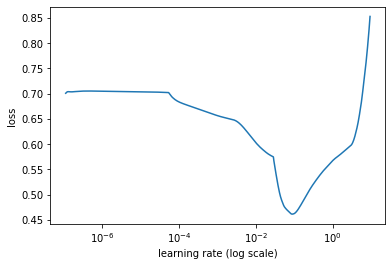

In [28]:
learner.lr_find()
learner.lr_plot()

Train the model using the optimal learning rate ( adjust argument as needed accorfing to the graph)

In [ ]:
learner.freeze(6)

In [29]:
learner.autofit(0.1)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.1...
Epoch 1/1024
632/632 [==============================] - 10s 15ms/step - loss: 0.5049 - accuracy: 0.6293 - val_loss: 0.5063 - val_accuracy: 0.6058
Epoch 2/1024
632/632 [==============================] - 9s 14ms/step - loss: 0.5583 - accuracy: 0.5196 - val_loss: 0.6351 - val_accuracy: 0.3688
Epoch 3/1024
631/632 [============================>.] - ETA: 0s - loss: 0.6361 - accuracy: 0.3742
Epoch 00003: Reducing Max LR on Plateau: new max lr will be 0.05 (if not early_stopping).
632/632 [==============================] - 9s 14ms/step - loss: 0.6361 - accuracy: 0.3743 - val_loss: 0.6333 - val_accuracy: 0.3688
Epoch 4/1024
632/632 [==============================] - 9s 15ms/step - loss: 0.6327 - accuracy: 0.3732 - val_loss: 0.6341 - val_accuracy: 0.3688
Epoch 5/1024
629/632 [============================>.] - ETA: 0

It's time for some fun! First, save the model and get a predictor instance that uses our pre-trained model

In [10]:
predictor = ktrain.get_predictor(learner.model, preproc)
predictor.save('detector_model_fasttext_my')
print('MODEL SAVED')

MODEL SAVED


Let's see if it can catch an SQLi or XSS payload

In [ ]:
import pickle
from tensorflow.keras.models import load_model
# loading preprocess and model file
features = pickle.load(open('detector_model_fasttext_gaussian/tf_model.preproc',
                            'rb'))
new_model = load_model('detector_model_fasttext_gaussian/tf_model.h5')
labels = ['benign', 'sqli', 'xss']

In [ ]:
new_model.print_layers()

In [ ]:
text = '<applet onkeydown="alert(1)" contenteditable>test</applet>'
preproc_text = features.preprocess([text])
result = new_model.predict(preproc_text)
print(result)
label = labels[result[0].argmax(axis=0)]
score = ('{:.2f}'.format(round(np.max(result[0]), 2)*100))
print('LABEL :', label, 'SCORE :', score)